In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

(walkthrough:scan_and_detect)=
# Scan and detect
Scanning imaging modes such as STEM works by rastering the electron probe across the sample pixel by pixel and recording the scattering signal for each position. To simulate this we have to perform a multislice simulation for every probe position.

## Scanned multislice

We start by creating a model of MoS<sub>2</sub>, we repeat the unit cell to accomodate the size of the probe wave function.

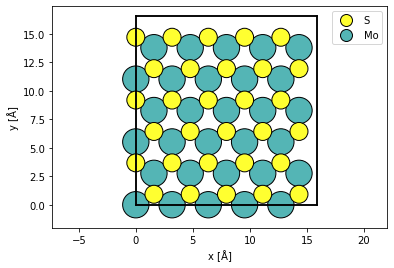

In [2]:
atoms = ase.build.mx2(vacuum=2)

atoms = abtem.orthogonalize_cell(atoms)

atoms = atoms * (5, 3, 1)

abtem.show_atoms(atoms, legend=True);

Next, we create a `Probe` with an energy of $80 \ \mathrm{keV}$ and a convergence semiangle of $30 \ \mathrm{mrad}$.

In [3]:
potential = abtem.Potential(atoms, sampling=0.05)

probe = abtem.Probe(energy=80e3, semiangle_cutoff=30, sampling=0.05)

abTEM implements three scan types:

* `GridScan`: Uniformly spaced axis-aligned 2d grid of probe positions.
* `LineScan`: Uniformly spaced probe positions along a line with an arbitrary direction.
* `CustomScan`: Defines the probe positions as an arbitrary $N \times 2$ array of numbers.

The `GridScan` is most commonly used, however, the `LineScan` may be a way to save computations. 

Below we create a `LineScan` by giving the `start` and `end` point as a fraction of the `potential.extent`. We specify 100 grid points along the scan. We set `endpoint=False`, because the scan covers a periodic region and thus the specified `start` and `end` is equivalent. Setting `endpoint=False` when scanning over a periodic unit will allow us to tile the resulting measurement. 

The scan types may be visualized on top of a visualization of the atoms using `add_to_plot`. 

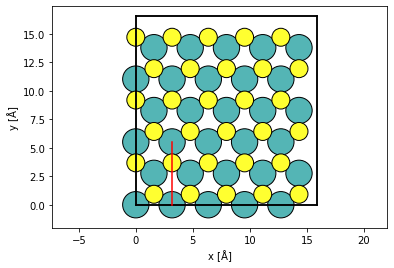

In [4]:
line_scan = abtem.LineScan(
    start=(potential.extent[0] / 5., 0.),
    end=(potential.extent[0] / 5., potential.extent[1] / 3.),
    gpts=100,
    endpoint=False,
)

fig, ax = abtem.show_atoms(atoms)
line_scan.add_to_plot(ax)

Calling `multislice` with the `LineScan` and `Potential` will result in the exit wave functions for every probe position along the scan, i.e. an ensemble of $100$ wave functions. 

In [5]:
exit_waves_line = probe.multislice(potential, scan=line_scan)

exit_waves_line.shape

(100, 318, 331)

## Applying detectors
In experiments, the exit wave functions are measured using detectors, correspondingly `abTEM` implements several detector types. For now, we shall focus on the `AnnularDetector`, which, depending on the choice of integration region, can represent the detector used in bright-field, medium- or high-angle annular dark-field microscopy, abbreviated BF, MAADF and HAADF, respectively.

Below we create a detector for BF, MAADF and HAADF by specifying the inner and outer radial integration angle in $\mathrm{mrad}$.

In [6]:
bright = abtem.AnnularDetector(inner=0, outer=30)
maadf = abtem.AnnularDetector(inner=50, outer=120)
haadf = abtem.AnnularDetector(inner=90, outer=200)

print(
    f"Maximum simulated scattering angle = {min(exit_waves_line.cutoff_angles):.1f} mrad"
)

Maximum simulated scattering angle = 278.0 mrad


We note that the maximum simulated angle ($278 \ \mathrm{mrad}$) is greater than the maximum detected angle ($200 \ \mathrm{mrad}$). An error will be thrown, if this is not true, in that case you need to increase the real space `sampling` of the `Probe`.

The detectors can be applied by using `detect`. As we used a `LineScan`, the exit wave functions are converted to `RealSpaceLineProfiles`.

In [7]:
haadf.detect(exit_waves_line)

Scanning and detecting may be combined when using `scan` producing a list of `LineProfiles` with an entry corresponding to each detector.

In [8]:
all_detectors = [bright, maadf, haadf]

measurements = probe.scan(potential, detectors=all_detectors, scan=line_scan).compute();

[########################################] | 100% Completed | 4.24 sms


We show the `RealSpaceLineProfiles` below.

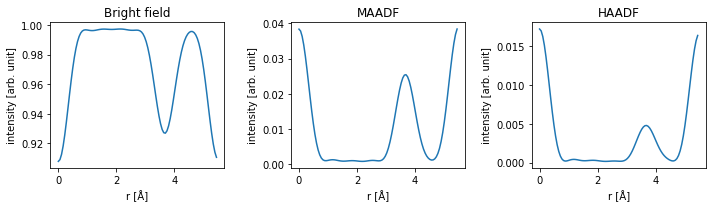

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
measurements[0].show(ax=ax1, title="Bright field")
measurements[1].show(ax=ax2, title="MAADF")
measurements[2].show(ax=ax3, title="HAADF")

fig.tight_layout()

The probe is normalized to integrate to $1$ in Fourier space. Looking at the plot showing the bright field intensity, we can conclude that there is almost no scattering in the hexagon centers (i.e. for $r\sim 2 \ \mathrm{Å}$), while $\sim10 \%$ of the electrons scatter outside the bright-field disk when the probe is placed directly on the atoms (i.e. for $r = 0$).

## STEM simulations

We perform STEM simulations using a `GridScan` much the same as we did with the `LineScan` above. We define a scan across a periodic unit of the potential using fractional coordinates with the alternate initializer `from_fractional_coordinates`. The probe step size (or `sampling`) is set to the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency) of the probe contrast transfer function.

In [10]:
sampling = probe.aperture.nyquist_sampling
print(f"Nyquist sampling = {sampling:.3f} Å/pixel")

Nyquist sampling = 0.348 Å/pixel


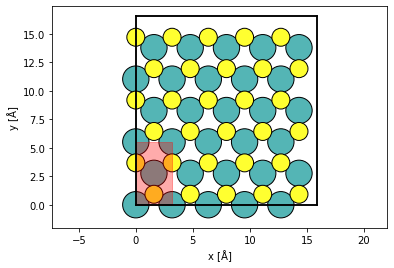

In [11]:
grid_scan = abtem.GridScan.from_fractional_coordinates(
    potential, start=[0, 0], end=[1 / 5, 1 / 3], sampling=sampling
)

fig, ax = abtem.show_atoms(atoms)
grid_scan.add_to_plot(ax)

We setup the STEM simulation resulting in a list of `Images`. 

In [12]:
measurements = probe.scan(potential, scan=grid_scan, detectors=all_detectors)
measurements

It is convenient to stack the measurements into a single `Images`, now they can be saved as a single file.

In [13]:
measurements = abtem.stack(measurements, ("BF", "MAADF", "HAADF"))

We write the `Images` to disk directly, this will trigger the computations to run.

In [14]:
measurements.to_zarr("mos2_stem_measurements.zarr");

[########################################] | 100% Completed | 6.54 sms


We show the resulting `Images` below.

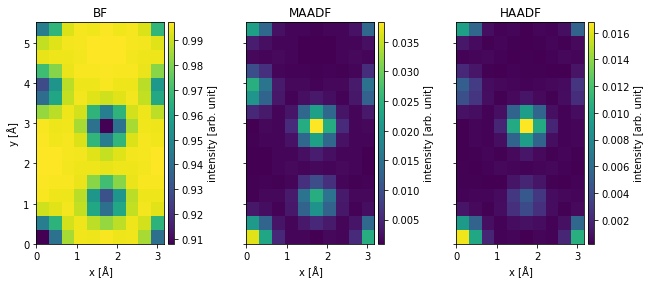

In [15]:
imported_measurements = abtem.from_zarr("mos2_stem_measurements.zarr")

imported_measurements.show(
    explode=True, cbar=True, image_grid_kwargs={"axes_pad": 1}, figsize=(10, 5)
);

## Post-processing STEM measurements

STEM multislice simulations usually requires some post-processing. We apply the most common post-processing steps below.

We saved a lot of computations by scanning at the Nyquist frequency, however, the result is quite pixelated. To fix this we interpolate the images to a sampling of $0.1 \ \mathrm{Å / pixel}$. abTEMs default interpolation algorithm is Fourier space padding, however, spline interpolation is also available, which is more appropriate if the image in non-periodic.

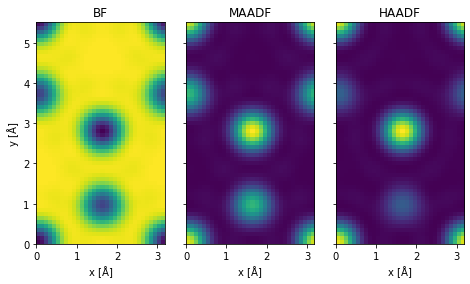

In [16]:
interpolated_measurement = imported_measurements.interpolate(sampling=0.1)

interpolated_measurement.show(explode=True, figsize=(12, 4));

A finite Gaussian-shaped source, often referred to as partial spatial coherence, will result in a Gaussian blurring of the image. Vibrations and other instabilities may further contribute to the blurring. We apply a Gaussian blur with a standard deviation of $0.3 \ \mathrm{Å}$ (corresponding to a source of approximately that size).

```{seealso}
We are not including partial temporal incoherence here. See our [walkthrough on partial coherence](walkthrough:partial_coherence) in STEM simulations for a detailed description. 
```

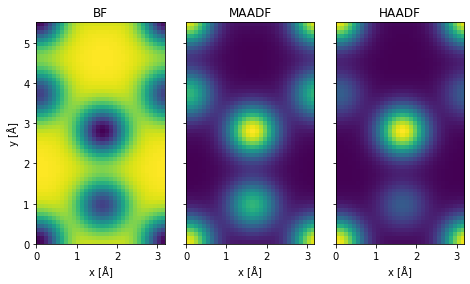

In [17]:
blurred_measurement = interpolated_measurement.gaussian_filter(0.3)

blurred_measurement.show(explode=True, figsize=(12, 4));

The image above corresponds to the limit of an infinite electron dose. An image with a finite electron dose will contain [shot noise](https://en.wikipedia.org/wiki/Shot_noise). We can get a random sample with finite dose by drawing random numbers from a Poisson distribution for every pixel. The Poisson distribution has a mean of

$$
    \lambda = \mathrm{area \ per \ pixel} \times \mathrm{dose \ per \ area} \times \mathrm{intensity} \quad ,
$$

where it is assumed that intensity of the Fourier space probe is normalized to integrate to $1$.

Before applying the noise, we tile the images to get better statistics.

In [18]:
tiled_measurement = blurred_measurement.tile((7, 4))

We apply Poisson noise corresponding a dose per area of $5\times 10^4 \ e^- / \mathrm{Å}$.

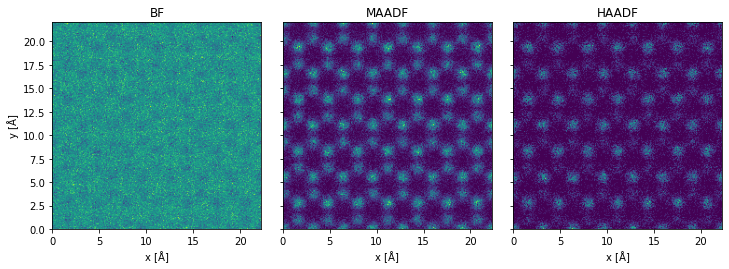

In [19]:
noisy_measurement = tiled_measurement.poisson_noise(dose_per_area=5e4)

noisy_measurement.show(explode=True, figsize=(12, 4));

Poisson noise is generally the most important source of noise in STEM images, however, scan noise due to vibrations and voltage instabilities in the scan coils may be significant{cite}`jones_scan_noise`, see `abtem.measure.apply_scan_noise`. For completeness thermal noise in the detector material may also contribute to the noise. 

## Detectors

abTEM implements the following detector types:

* `AnnularDetector`: Integrates diffraction patterns between two scattering angles. Used for BF, MAADF and HAADF.
* `FlexibleAnnularDetector`: Bins diffraction patterns in radial regions. Used for BF, MAADF and HAADF.
* `SegmentedDetector`: Bins diffraction patterns in radial and azimuthal regions. Used for differential phase constrast STEM (DPC-STEM).
* `PixelatedDetector`: Detects full diffraction patterns. Used for 4D-STEM.
* `WavesDetector`: Detects the full wave function. Mostly for internal use.

The `AnnularDetector` was introduced in the preceding section, in the following the rest of the detectors are introduced.

### `FlexibleAnnularDetector`

The `FlexibleAnnularDetector` radially bins the diffraction pattern, thus allowing us to choose the integration limits after running the simulation. Compared to saving a the full diffraction, the advantage of this detector is the significantly reduced memory or disk usage. The `FlexibleAnnularDetector` is the default detector in abTEM.

Here, we create a detector with a spacing between detector bins of $10 \ \mathrm{mrad}$.

In [20]:
flexible_detector = abtem.FlexibleAnnularDetector(step_size=10)

We run the scanned multislice simulations.

In [21]:
flexible_measurement = probe.scan(
    potential, scan=grid_scan, detectors=flexible_detector
)

The result is `PolarMeasurements`; the measurement values are binned on a uniform polar grid, where two base axes represents the radial and azimuthal directions, repsectively. In this case, there is only a single azimuthal coordinate.

In [22]:
flexible_measurement.axes_metadata

type        label                             coordinates
----------  --------------------------------  ---------------------
ScanAxis    x [Å]                             0.00 0.32 ... 2.86
ScanAxis    y [Å]                             0.00 0.34 ... 5.16
LinearAxis  Radial scattering angle [mrad]    0.00 10.00 ... 260.00
LinearAxis  Azimuthal scattering angle [rad]  0.00

We can reproduce the BF, MAADF and HAADF measurements obtained from the `AnnularDetector` above by integrating the `PolarMeasurements`.

In [23]:
stacked = abtem.stack(
    [
        flexible_measurement.integrate_radial(0, 30),
        flexible_measurement.integrate_radial(50, 120),
        flexible_measurement.integrate_radial(90, 200),
    ],
    ("BF", "MAADF", "HAADF"),
).compute()

[########################################] | 100% Completed | 6.20 sms


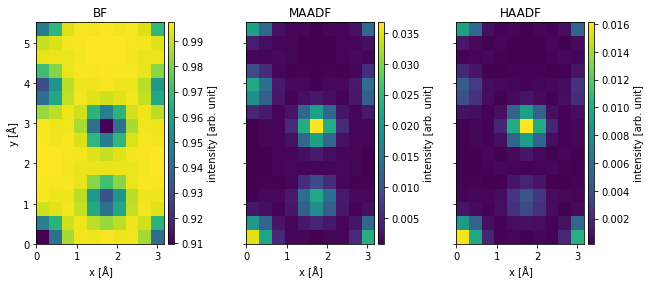

In [24]:
stacked.show(
    explode=True, cbar=True, image_grid_kwargs={"axes_pad": 1}, figsize=(10, 5)
);

### `SegmentedDetector`

The `SegmentedDetector` covers an annular region and is partitioned into several detector regions forming radial and azimuthal segments. 

Below we define a `SegmentedDetector` covering the annular region between $40$ and $80 \ \mathrm{mrad}$. It is divided 
into $2$ radial regions, each of which are divided into $4$ azimuthal regions. The detector regions are rotated by $45 \ \mathrm{deg.}$ with respect to the cartesian axes.

In [25]:
segmented_detector = abtem.SegmentedDetector(
    inner=40, outer=80, nbins_radial=2, nbins_azimuthal=4, rotation=np.pi / 4
)

We may illustrate the detector regions below using a polar plot.

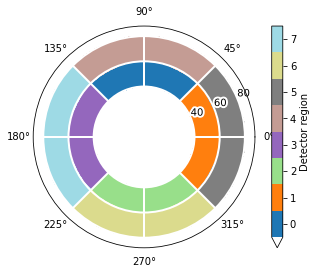

In [26]:
segmented_detector.show(radial_ticks=[40, 60, 80]);

We run the scanned multislice simulations. The resulting `PolarMeasurement` is 4d, the first two (ensemble) axes represents the scan directions and the last two (base) axes represents the radial and azimuthal bin axes.

In [27]:
segmented_measurement = probe.scan(
    potential, scan=grid_scan, detectors=segmented_detector
)

segmented_measurement.compute()

[########################################] | 100% Completed | 5.99 sms


We show the detected intensities for scan position `(1, 1)` on a polar plot. This scan position is offset from the atom at $(x,y) = (0,0)$ at an angle of $~ 45 \ \mathrm{deg.}$, hence the electric field attracts the electrons towards the opposite direction, i.e. the detector regions at $~ 225 \ \mathrm{deg.}$

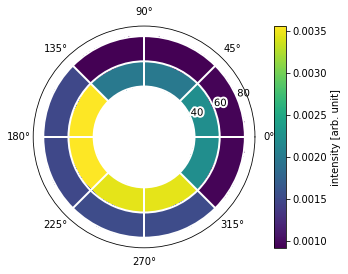

In [28]:
segmented_measurement[1, 1].show(radial_ticks=[40, 60, 80], cbar=True, figsize=(7,4));

Below we calculate the differential signals in the $x$- and $y$-directions. The differential signal in the $x$-direction is calculated as the difference between detector regions 1 and 3, for the $y$-direction it is the difference between detector regions 0 and 2.

In [29]:
differential = segmented_measurement.differentials(
    direction_1_plus=(1,),
    direction_1_minus=(3,),
    direction_2_plus=(0,),
    direction_2_minus=(2,),
    return_complex=True,
)

The differential signal is returned as complex `Images`, where the real and imaginary parts correspond to the $x$- and $y$-direction, respectively.

To show the results, we first interpolate and tile. The different representations of the complex parts are stacked to show an exploded plot.

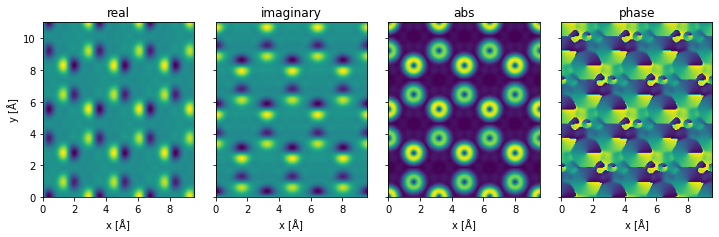

In [30]:
interpolated_differential = differential.interpolate(0.05).tile((3, 2))

abtem.stack(
    [
        interpolated_differential.real(),
        interpolated_differential.imag(),
        interpolated_differential.abs(),
        interpolated_differential.phase(),
    ],
    ("real", "imaginary", "abs", "phase"),
).show(explode=True, figsize=(12, 4));

We can also display the complex `Images` using domain coloring.

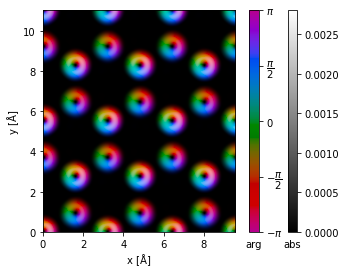

In [31]:
interpolated_differential.show(cbar=True, vmax=0.0028, vmin=0);

### `PixelatedDetector`

The `PixelatedDetector` records the diffraction patterns for every probe position. Hence, a 2D scan with this detector results in a four-dimensional dataset. The 4D datasets can be used to reconstruct the results of all the other detector geometries. 

Below we create a `PixelatedDetector` saving the diffraction patterns up to $200 \ \mathrm{mrad}$ and run the scanned multislice algorithm.

In [32]:
pixelated_detector = abtem.PixelatedDetector(max_angle=200)

pixelated_measurements = probe.scan(
    potential,
    scan=grid_scan,
    detectors=pixelated_detector,
)
pixelated_measurements.compute()

[########################################] | 100% Completed | 5.89 sms


We show the detected intensities for scan position `(1, 1)` on up to $80 \ \mathrm{mrad}$. Since the diffraction pattern is dominated by the direct disk, we show it in three different ways: with no modifications, on a power scale with a small power of $0.1$ and blocking the direct disk.

We can make the same observation, as we did for the `SegmentedDetector`; the electrons are attracted in the direction of the atomic potential.

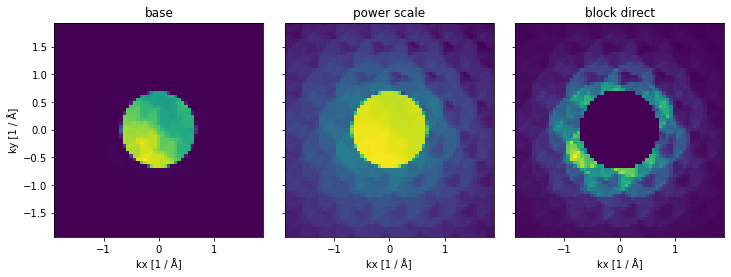

In [33]:
cropped_diffraction_pattern = pixelated_measurements[1, 1].crop(max_angle=80)

abtem.stack(
    [
        cropped_diffraction_pattern,
        cropped_diffraction_pattern**0.1,
        cropped_diffraction_pattern.block_direct(),
    ],
    ("base", "power scale", "block direct"),
).show(explode=True, figsize=(12, 4));

We can obtain the annular integrated measurements from the diffraction patterns as shown below. 

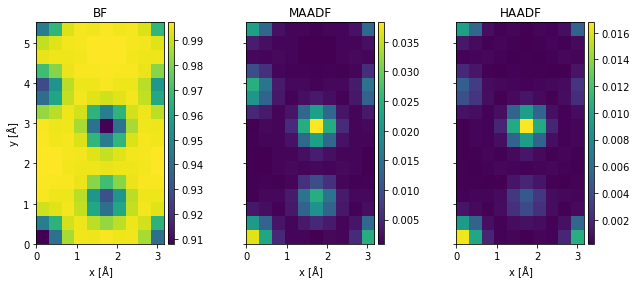

In [34]:
stacked = abtem.stack(
    [
        pixelated_measurements.integrate_radial(0, 30),
        pixelated_measurements.integrate_radial(50, 120),
        pixelated_measurements.integrate_radial(90, 200),
    ],
    ("BF", "MAADF", "HAADF"),
)

stacked.show(
    explode=True, cbar=True, image_grid_kwargs={"axes_pad": 1}, figsize=(10, 5)
);

The center of mass (COM) of a diffraction pattern may be calculated as

$$
    \vec{k}_{com} = \int \hat{I}(\vec{k}) \vec{k} d\vec{k} \quad ,
$$

where $\hat{I}(\vec{k})$ is a diffraction pattern intensity. Doing this for every diffraction pattern, we obtain the image shown below. The center of mass is returned as complex `Images`, where the real and imaginary parts correspond to the $x$- and $y$-direction, respectively. We set `units="reciprocal"`, hence each complex component is in units of $mrad$.

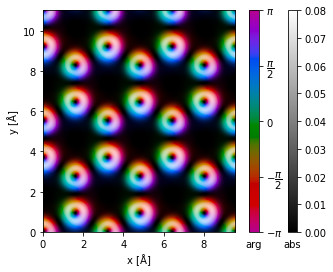

In [35]:
center_of_mass = pixelated_measurements.center_of_mass(units="reciprocal")

interpolated_center_of_mass = center_of_mass.interpolate(0.05).tile((3, 2))

interpolated_center_of_mass.show(cbar=True, vmax=0.08, vmin=0);

Interpreting the real and imaginary part of the COM as the gradient in $x$ and $y$, we may integrate it to obtain the integrated center of mass (iCOM).

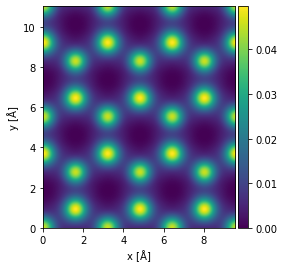

In [36]:
integrated_gradient = center_of_mass.integrate_gradient()

interpolated_integrated_gradient = integrated_gradient.interpolate(0.05).tile((3, 2))

interpolated_integrated_gradient.show(cbar=True);